In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Import data

In [2]:
flight_data = pd.read_csv('data/flight_data.csv')
weather_forecast = pd.read_csv('data/weather_forecast.csv')

# convert date and time column to datetime
weather_forecast['date_and_time'] = pd.to_datetime(weather_forecast['date_and_time'])

### Weather Visualisations

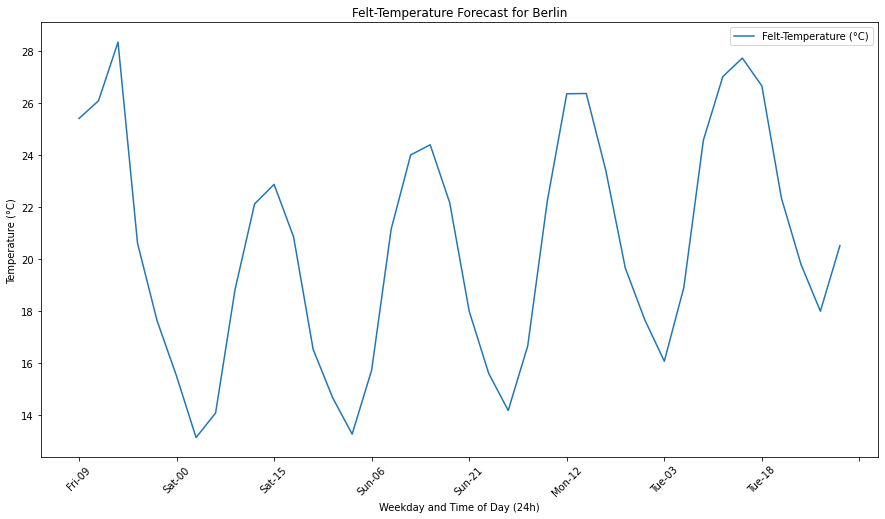

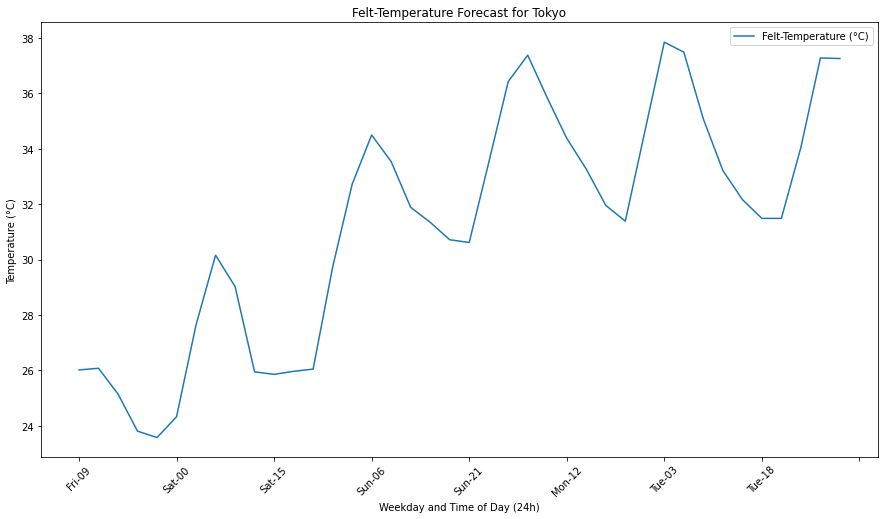

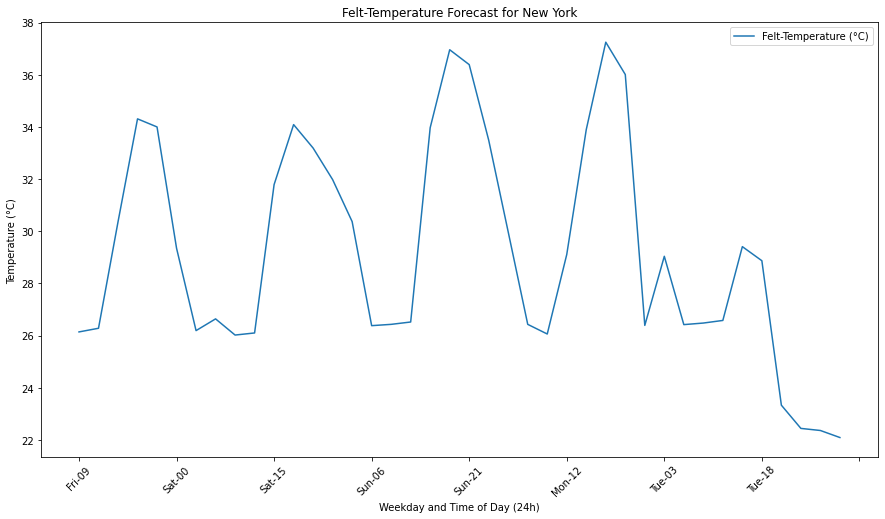

In [5]:
# create df with temperature information only
temp_df = (
    weather_forecast
        .loc[:, ['city_ascii', 'date_and_time', 'min_temp', 'max_temp', 'felt_temp']]
        .assign(day_time = weather_forecast['date_and_time'].dt.strftime('%a-%H'))
        )
city_list = list(temp_df.city_ascii.unique())

# line-graph showing max-temperature forecast for each city
for city in city_list:
    temp_df.loc[temp_df['city_ascii']== city,:].plot(
        x = 'day_time',
        y = 'felt_temp',
        rot= 45,
        figsize = (15,8),
        xlabel = 'Weekday and Time of Day (24h)',
        ylabel = 'Temperature (°C)',
        title = f'Felt-Temperature Forecast for {city}'
        )
    plt.legend(['Felt-Temperature (°C)'])
    plt.savefig(f'visualisations\\weather\\max_temp_forecast_{city}.svg')
    plt.show()

### Flight Visualisations

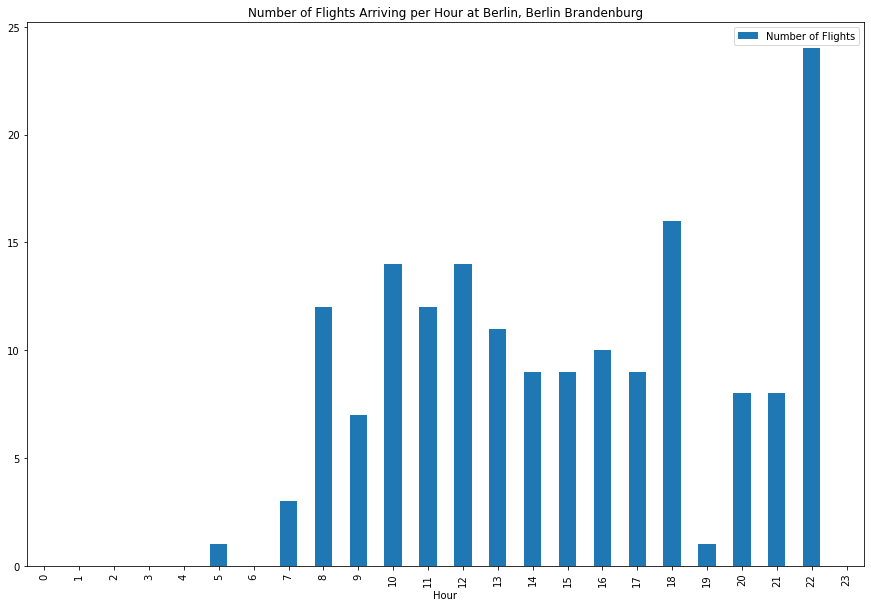

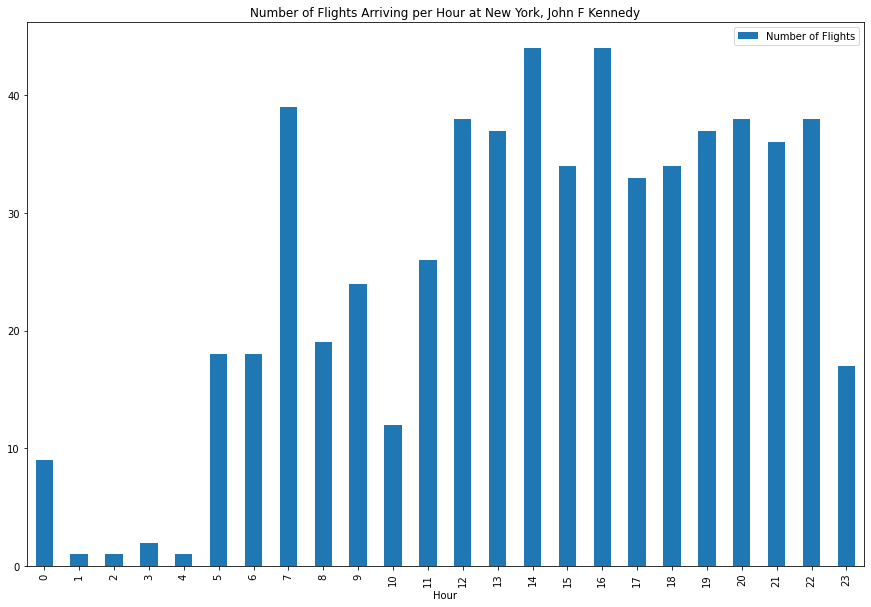

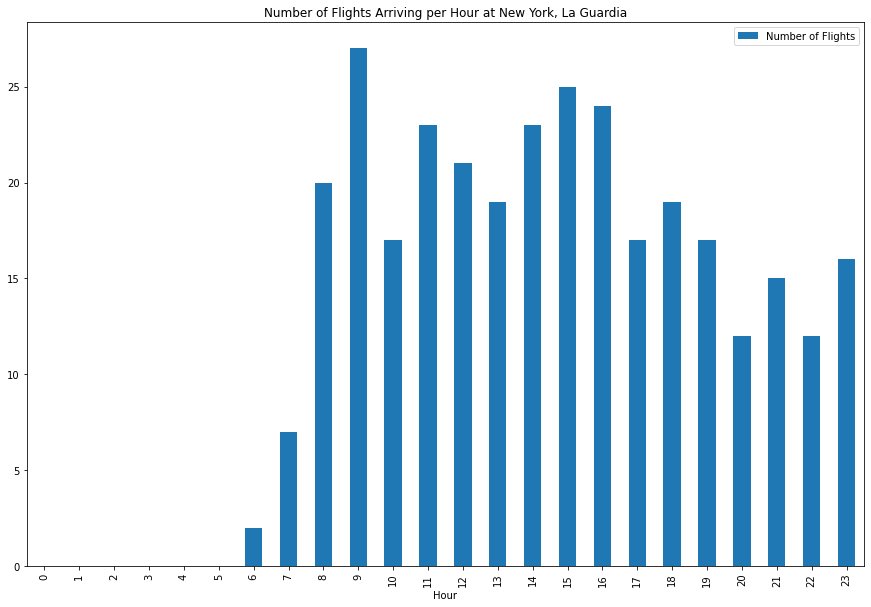

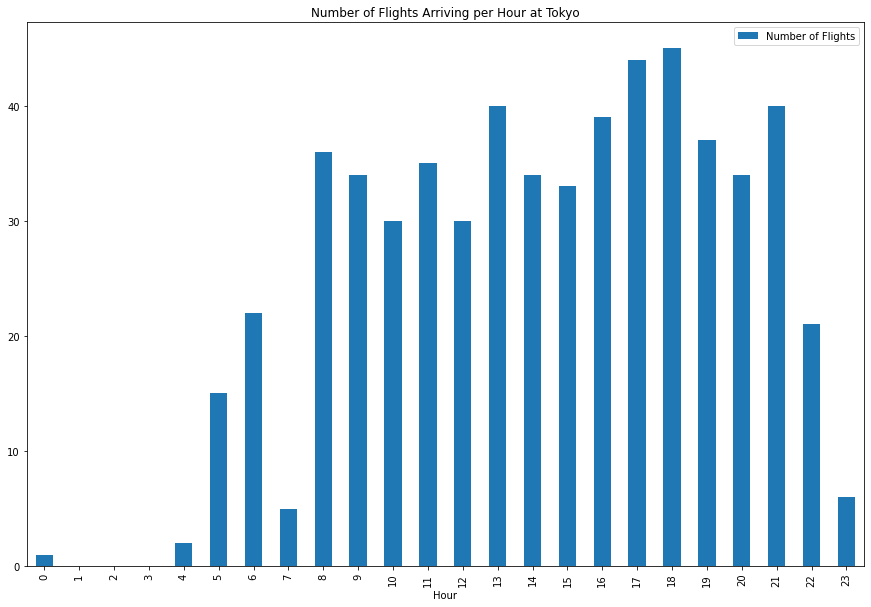

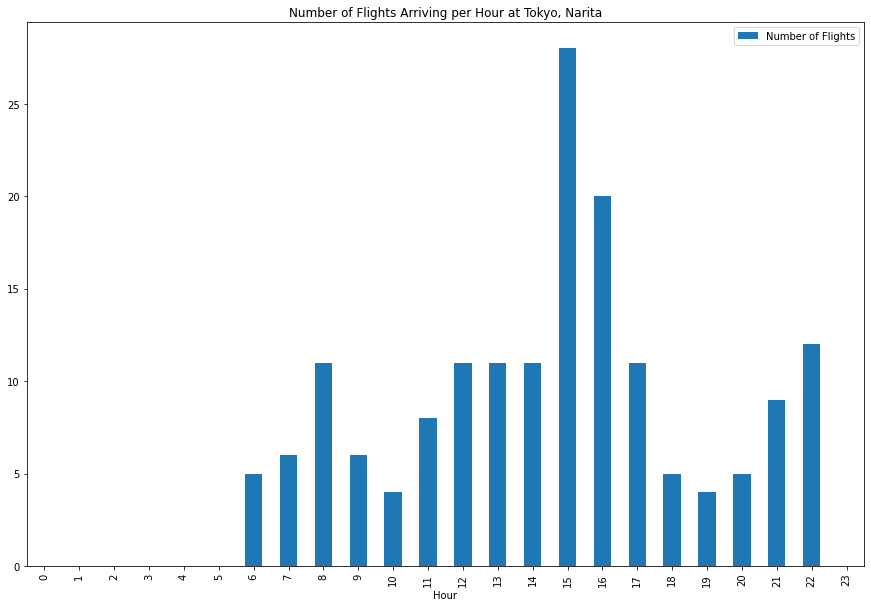

In [8]:
# visualize number of flights incoming per hour
inc_flights_df = (
    flight_data
        .assign(hour = flight_data['scheduled_time_local'].str[11:13].astype('int'))
        .groupby(['arrival_airport_name', 'hour'])
        .agg(nr_of_flights = ('flight_id', 'count'))
        .reset_index()
    )

# create dummy dataframe to fill hours without any planes arriving with the number 0 
dummy_dict = {
    'hour': range(24),
    'nr_of_flights': [0]*24
    }
dummy_df = pd.DataFrame(dummy_dict)

inc_flights_df = (
    pd.merge_ordered(dummy_df, inc_flights_df, how='left', on = 'hour', right_by= 'arrival_airport_name')
        .sort_values(by = ['arrival_airport_name', 'hour'])
        .fillna(0)
        .drop(columns= 'nr_of_flights_x')
        .rename(columns= {'nr_of_flights_y' : 'nr_of_flights'})
        .sort_values(by= ['arrival_airport_name', 'hour'])
        )

# create plots
for airport in inc_flights_df['arrival_airport_name'].unique():
    
    ax =inc_flights_df.loc[inc_flights_df['arrival_airport_name'] == airport].plot.bar(
        x = 'hour',
        y = 'nr_of_flights',
        xlabel = 'Hour',
        title = f'Number of Flights Arriving per Hour at {airport}',
        figsize = (15, 10)
        )
    
    # allow only integer values on y-axis-ticks
    ax.yaxis.get_major_locator().set_params(integer=True) 

    fixed_airport_name = airport.replace(',', '').replace(' ', '_')
    plt.legend(['Number of Flights'])
    plt.savefig(f'visualisations\\airport\\flights_arriving_hourly_{fixed_airport_name}.svg')
    plt.show()